In [29]:
#!/usr/bin/env python3
%load_ext autoreload
%autoreload 2

from image_processor import Processor
from find_F_and_E import Finding_F_and_E
from triangulate import Triangulate_Points
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
DEBUG_OP = False

# LOAD ALL IMAGES AND NORMALIZE
p = Processor(DEBUG_OP)
imgs = p.load_images(['buddha_images'])

norm_imgs = []
seq_pairs = []

for i in tqdm(range(len(imgs))):
    norm_imgs.append(p.normalize(imgs[i], i, use_clahe=True))
    if i < 23:
        pair = (i, i+1)
        seq_pairs.append(pair)
print("IMAGES LOADED AND NORMALIZED")

#Add Initialization Pair
seq_pairs.append((0,4))
print(f"Seq Pairs:: {seq_pairs}")

KPS = {}
DES = {}
# USE SIFT ON ALL IMAGES
for idx, nimg in  enumerate(norm_imgs):
    f = Finding_F_and_E(DEBUG_OP)
    kp, des = f.use_sift(nimg)
    KPS[idx] = kp
    DES[idx] = des
print("SIFT ON ALL IMAGES COMPLETE")

inliers = {}
point_2d_1 = {}
point_2d_2 = {}
E_matrix = {}
R_matrix = {}
t_matrix = {}
cam_pose = {}
good_matches = {}

fx = fy = 1690
cx = norm_imgs[0].shape[0] / 2
cy = norm_imgs[0].shape[1] / 2

K = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])

Number of images loaded: 24



100%|██████████| 24/24 [00:00<00:00, 614.56it/s]

IMAGES LOADED AND NORMALIZED
Seq Pairs:: [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (0, 4)]


SIFT ON ALL IMAGES COMPLETE


In [31]:
for pair in tqdm(seq_pairs):
    f = Finding_F_and_E(DEBUG_OP)

    # Matching Keypoints for the Pair of Images
    f.knn_matching(pair, KPS[pair[0]], DES[pair[0]], KPS[pair[1]], DES[pair[1]], norm_imgs[pair[0]], norm_imgs[pair[1]])

    # Getting the Essential Matrix and All Other Required Information
    E, R, t, ins, src, dst, g_matches = f.compute_E(KPS[pair[0]], KPS[pair[1]], pair, K)
    E = f.enforce_rank2_matrix(E)

    E_matrix[pair] = E
    inliers[pair] = ins
    R_matrix[pair] = R
    t_matrix[pair] = t
    cam_pose[pair] = np.hstack((R, t))
    good_matches[pair] = g_matches

    SRC = src[ins.ravel() == 1]
    DST = dst[ins.ravel() == 1]
    
    point_2d_1[pair] = SRC
    point_2d_2[pair] = DST
print("EXTRACTED 2D POINTS WITH ALL OTHER REQUIRED INFORMATION FOR THE SEQUENTIAL PAIRS")

prev_pair = None
all_cam_pose = {}
all_3d_points = {}
all_R = {}
all_t = {}

100%|██████████| 24/24 [00:02<00:00,  8.24it/s]

EXTRACTED 2D POINTS WITH ALL OTHER REQUIRED INFORMATION FOR THE SEQUENTIAL PAIRS


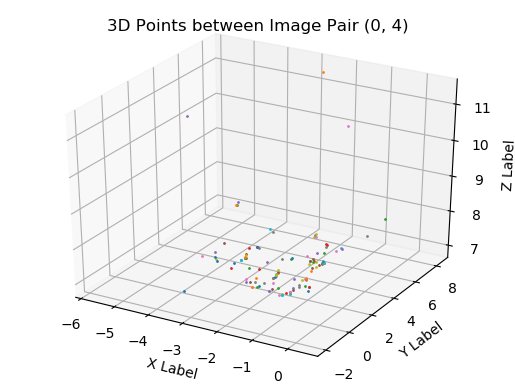

In [32]:
# Initialization
i_pair =(0, 4)
p3d = Triangulate_Points(True, pair)

# Relative Pose for the Initalization Pair Will also be Their Absolute Poses
all_R[i_pair[0]], all_t[i_pair[0]] = np.eye(3), np.zeros((3, 1))
all_R[i_pair[1]], all_t[i_pair[1]] = R_matrix[i_pair], t_matrix[i_pair]

# Trianguating Points
points_4d_homogeneous = p3d.triangulate(K, all_R[i_pair[0]],all_R[i_pair[1]], all_t[i_pair[0]], all_t[i_pair[1]], point_2d_1[i_pair], point_2d_2[i_pair])
points_3d = points_4d_homogeneous[:3, :] / points_4d_homogeneous[3, :]
points_3d = points_3d.T

points_3d, mask = p3d.remove_outlier_3D_points(points_3d)

if True:
    p3d.plot_3d(points_3d)


In [33]:
point_2d_1[i_pair] = point_2d_1[i_pair][mask.ravel()==1]
point_2d_2[i_pair] = point_2d_2[i_pair][mask.ravel()==1]

all_cam_pose[i_pair[0]] = np.dot(K, np.hstack((all_R[i_pair[0]], all_t[i_pair[0]])))
all_cam_pose[i_pair[1]] = np.dot(K, np.hstack((all_R[i_pair[1]], all_t[i_pair[1]])))

all_3d_points[i_pair] = points_3d

In [34]:
def find_common_points_idx(past_pts, curr_pts):
    common_pt_idx_for_prev_iter = []
    common_pt_idx_for_curr_iter = []

    for i, pt1 in enumerate(past_pts):
        for j, pt2 in enumerate(curr_pts):
            if np.array_equal(pt1, pt2):
                if (i not in common_pt_idx_for_prev_iter and j not in common_pt_idx_for_curr_iter):
                    common_pt_idx_for_prev_iter.append(i)
                    common_pt_idx_for_curr_iter.append(j)
    
    return common_pt_idx_for_prev_iter, common_pt_idx_for_curr_iter

  0%|          | 0/24 [00:00<?, ?it/s]

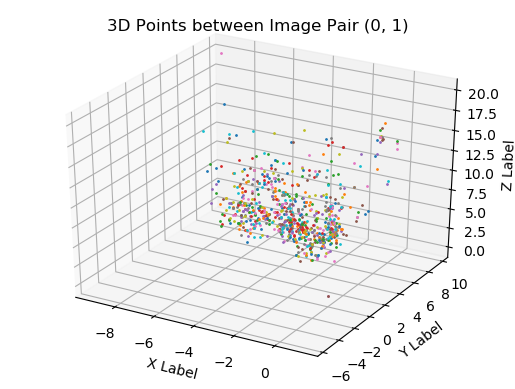

  4%|▍         | 1/24 [00:01<00:32,  1.42s/it]

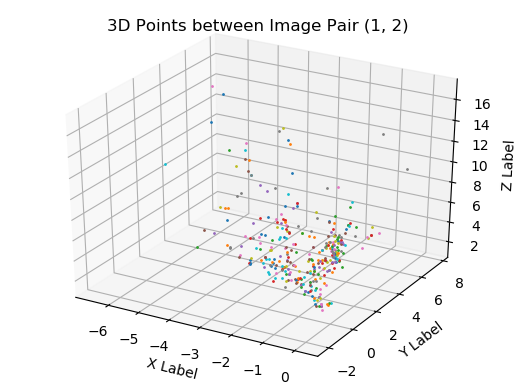

  8%|▊         | 2/24 [00:02<00:24,  1.13s/it]

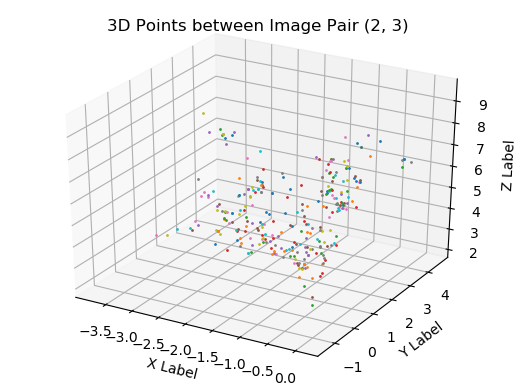

 12%|█▎        | 3/24 [00:03<00:19,  1.10it/s]

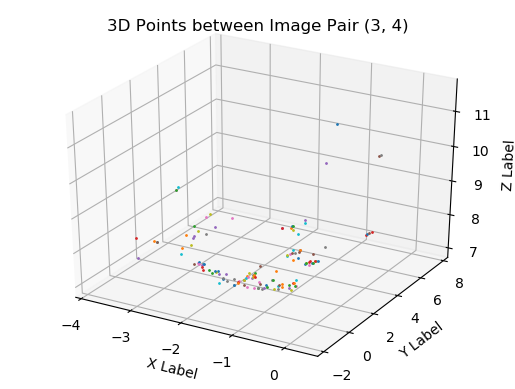

 17%|█▋        | 4/24 [00:03<00:13,  1.47it/s]

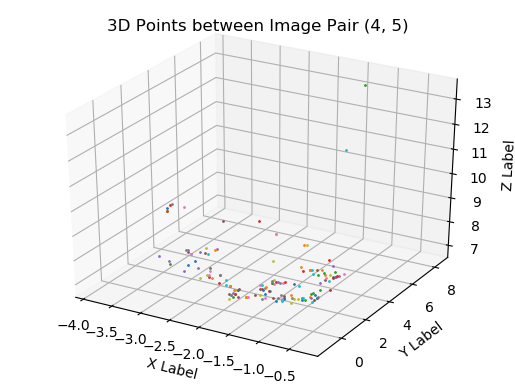

 21%|██        | 5/24 [00:03<00:10,  1.84it/s]

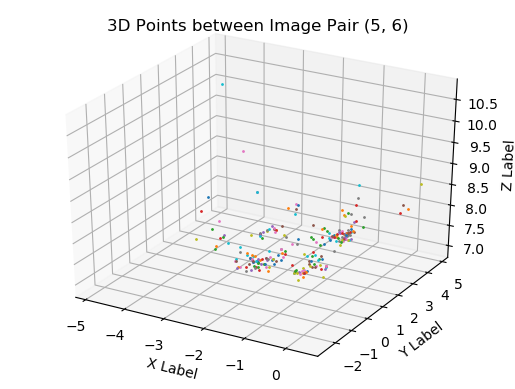

 25%|██▌       | 6/24 [00:04<00:09,  1.96it/s]

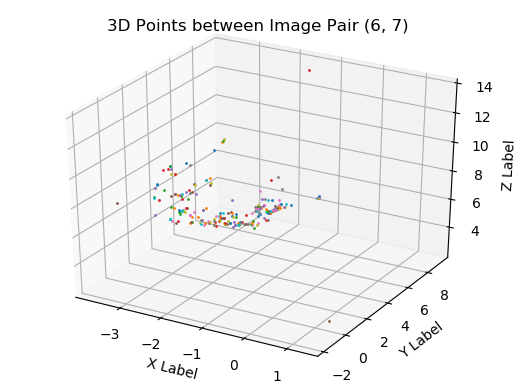

 29%|██▉       | 7/24 [00:04<00:08,  2.01it/s]

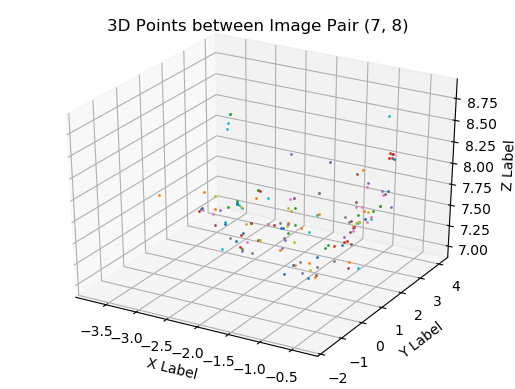

 33%|███▎      | 8/24 [00:05<00:07,  2.01it/s]

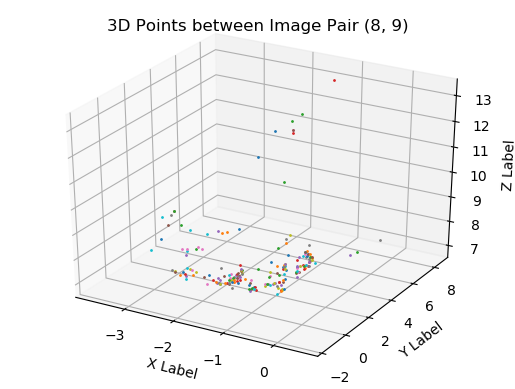

 38%|███▊      | 9/24 [00:05<00:07,  2.14it/s]

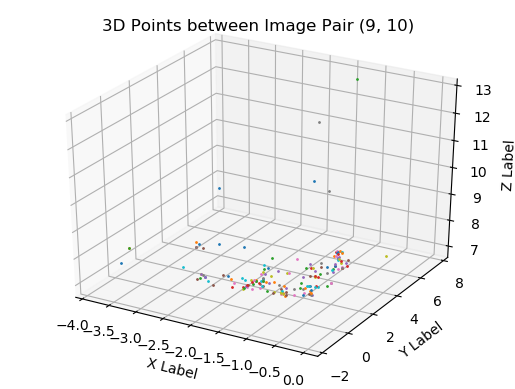

 42%|████▏     | 10/24 [00:05<00:06,  2.28it/s]

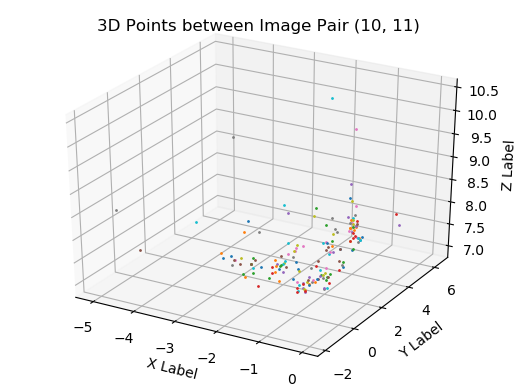

 46%|████▌     | 11/24 [00:06<00:05,  2.39it/s]

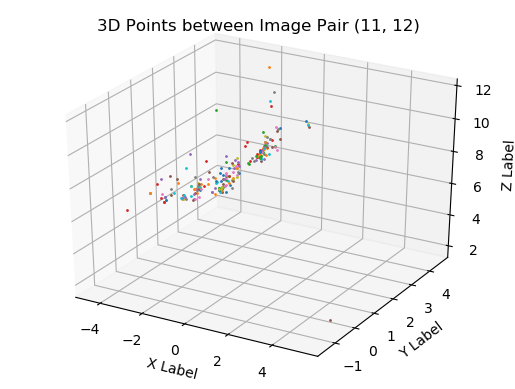

 50%|█████     | 12/24 [00:06<00:05,  2.33it/s]

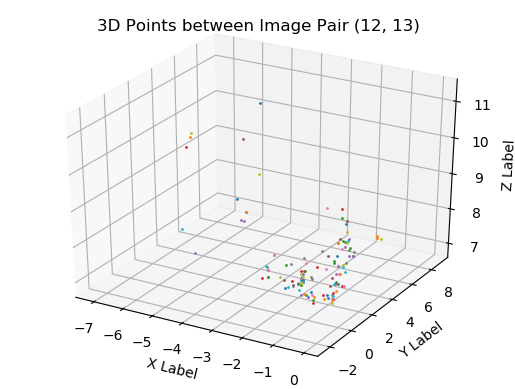

 54%|█████▍    | 13/24 [00:06<00:04,  2.62it/s]

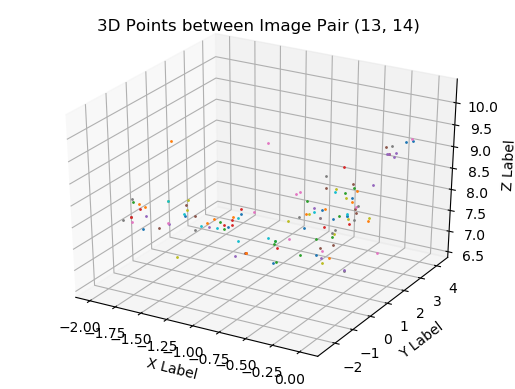

 58%|█████▊    | 14/24 [00:07<00:03,  2.79it/s]

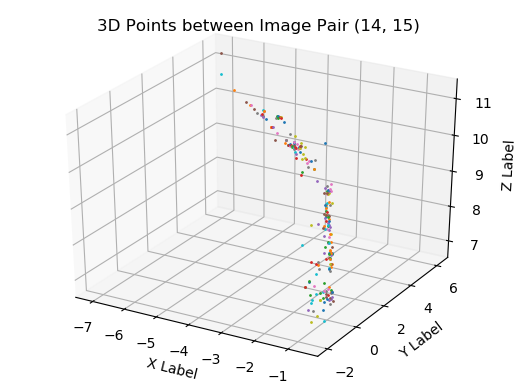

 62%|██████▎   | 15/24 [00:07<00:03,  2.63it/s]

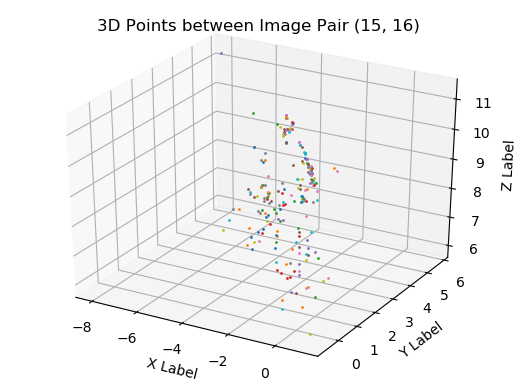

 67%|██████▋   | 16/24 [00:08<00:03,  2.47it/s]

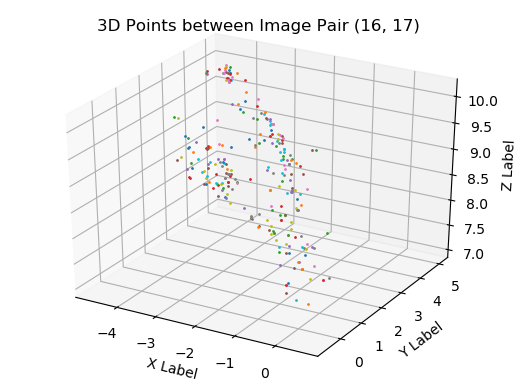

 71%|███████   | 17/24 [00:08<00:03,  2.05it/s]

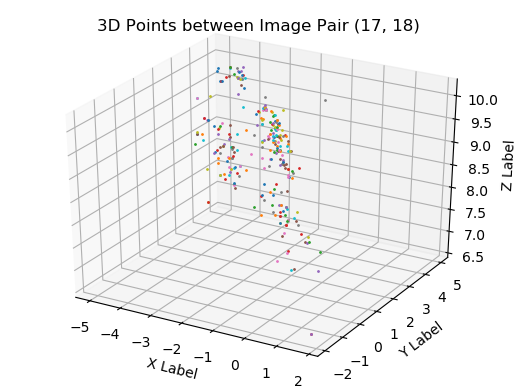

 75%|███████▌  | 18/24 [00:09<00:03,  1.96it/s]

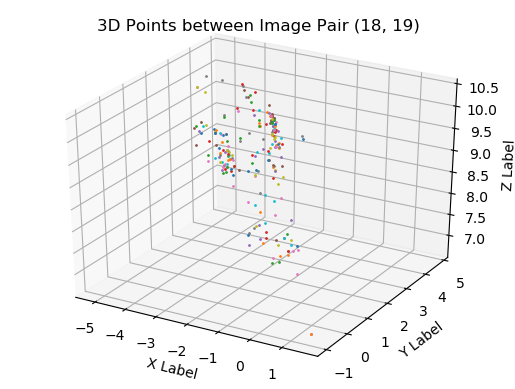

 79%|███████▉  | 19/24 [00:09<00:02,  2.01it/s]

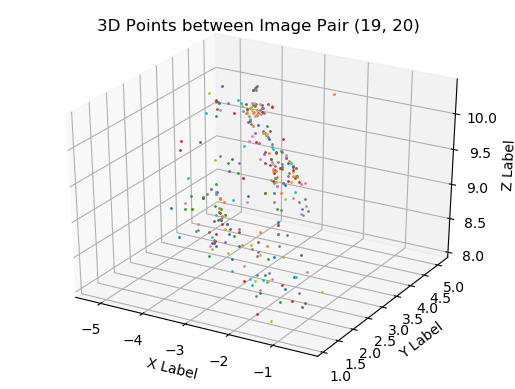

 83%|████████▎ | 20/24 [00:10<00:02,  1.82it/s]

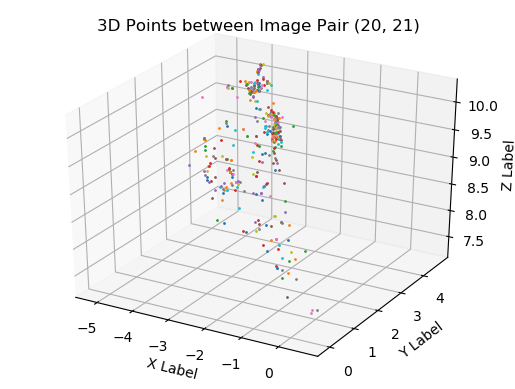

 88%|████████▊ | 21/24 [00:11<00:01,  1.61it/s]

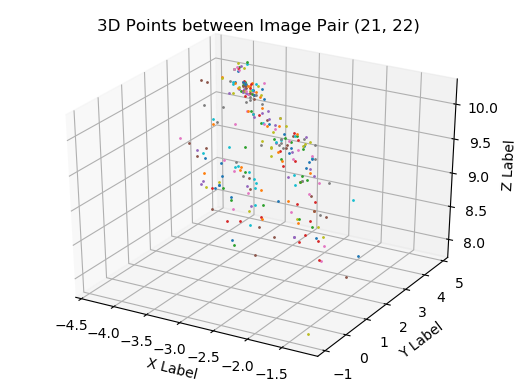

 92%|█████████▏| 22/24 [00:11<00:01,  1.63it/s]

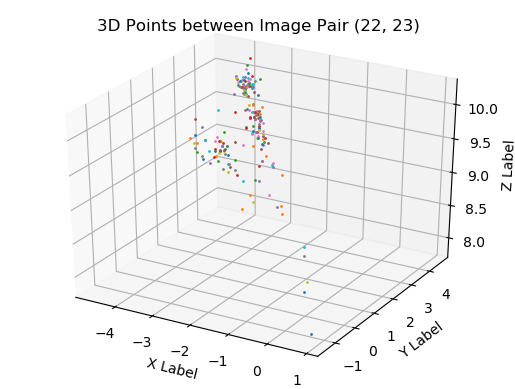

 96%|█████████▌| 23/24 [00:12<00:00,  1.77it/s]

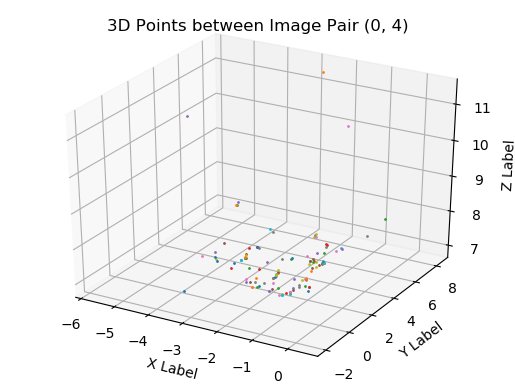

100%|██████████| 24/24 [00:12<00:00,  1.90it/s]

EXTRACTED 3D POINTS WITH ALL OTHER REQUIRED INFORMATION FOR THE SEQUENTIAL PAIRS


In [35]:
for pair in tqdm(seq_pairs):
    p3d = Triangulate_Points(False, pair)
    indices = []

    good_matches_curr = good_matches[pair]

    # Getting Points From Previous Pair
    if pair == (0,1):
        prev_pair = i_pair
        common_img_pts = point_2d_1[prev_pair]
    else:
        common_img_pts = point_2d_2[prev_pair]

    src_pts = np.float32([KPS[pair[0]][match.queryIdx].pt for match in good_matches_curr]).squeeze()
    dst_pts = np.float32([KPS[pair[1]][match.trainIdx].pt for match in good_matches_curr]).squeeze()
    curr_inliers = inliers[pair].ravel()
    
    src_pts = src_pts[curr_inliers == 1]
    dst_pts = dst_pts[curr_inliers == 1]

    # Getting the Indices of the Common Points
    (common_pt_idx_for_prev_iter, common_pt_idx_for_curr_iter) = find_common_points_idx(common_img_pts, src_pts)

    points_2d_pnp1 = src_pts[common_pt_idx_for_curr_iter]
    points_2d_pnp2 = dst_pts[common_pt_idx_for_curr_iter]

    points_2d_pnp_prev1 = common_img_pts[common_pt_idx_for_prev_iter]

    prev_3d_points = all_3d_points[prev_pair]
    points_3D_for_pnp = [prev_3d_points[idx] for idx in common_pt_idx_for_prev_iter]

    # Finding Absolute Camera Pose
    if pair[1] != 4:
        # Not Doing it for pair[1] == 4 Because it was Obtained During Initialization
        curr_R, curr_t = p3d.find_camera_pose(np.array(points_3D_for_pnp), np.array(points_2d_pnp2), K)
        all_R[pair[1]], all_t[pair[1]] = curr_R, curr_t
    
    # Triangulating Points
    points_4d_homogeneous = p3d.triangulate(K, all_R[pair[0]], all_R[pair[1]], all_t[pair[0]], all_t[pair[1]], src_pts, dst_pts)
    points_3d = (points_4d_homogeneous[:-1] / points_4d_homogeneous[-1])
    points_3d = points_3d.T

    points_3d, mask = p3d.remove_outlier_3D_points(points_3d)

    if True:
        p3d.plot_3d(points_3d)
    
    point_2d_1[pair] = src_pts[mask.ravel()==1]
    point_2d_2[pair] = dst_pts[mask.ravel()==1]

    all_cam_pose[pair[0]] = np.dot(K, np.hstack((all_R[pair[0]], all_t[pair[0]])))
    all_cam_pose[pair[1]] = np.dot(K, np.hstack((all_R[pair[1]], all_t[pair[1]])))

    all_3d_points[pair] = points_3d

    prev_pair = pair

print("EXTRACTED 3D POINTS WITH ALL OTHER REQUIRED INFORMATION FOR THE SEQUENTIAL PAIRS")

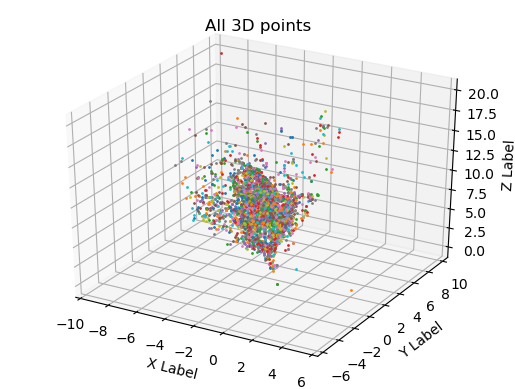

In [36]:
# Saving All 3D Points
list_of_all_3d_points = []

for key, points in all_3d_points.items():
    for point in points:
        list_of_all_3d_points.append(point)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point in list_of_all_3d_points:
    x, y, z = point
    ax.scatter(x, y, z, s=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title(f"All 3D points")

np.save("all_3d_points.npy", np.array(list_of_all_3d_points))

In [37]:
# Optimization
import gtsam
import gtsam.utils.plot as gt_plot

graph = gtsam.NonlinearFactorGraph()
L = gtsam.symbol_shorthand.L
X = gtsam.symbol_shorthand.X

calibration = gtsam.Cal3_S2(1690.0, 1690.0, 0, 540, 960)

msmt_NoiseSigma = 5
msmt_noise = gtsam.noiseModel.Isotropic.Sigma(2, msmt_NoiseSigma)

pose_prior_noise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.5, 0.5, 1, 0.1, 0.1, 0.1]))

prior_factor = gtsam.PriorFactorPose3(X(i_pair[0]), gtsam.Pose3(all_cam_pose[i_pair[0]]), pose_prior_noise)
graph.push_back(prior_factor)

# Adding 2D Points to the Graph that Correspond to a 3D Point
idx_3d = 0
for pair, _ in all_3d_points.items():
    src_2d = point_2d_1[pair]
    dst_2d = point_2d_2[pair]
    for pts_idx in range(len(src_2d)):
        graph.add(gtsam.GenericProjectionFactorCal3_S2(gtsam.Point2(src_2d[pts_idx]), msmt_noise, X(pair[1]), L(idx_3d), calibration,))
        graph.add(gtsam.GenericProjectionFactorCal3_S2(gtsam.Point2(dst_2d[pts_idx]), msmt_noise, X(pair[1]), L(idx_3d), calibration,))
        idx_3d += 1

initial_estimate = gtsam.Values()

for idx, pose in all_cam_pose.items():
    initial_estimate.insert(X(idx), gtsam.Pose3(pose))

idx_3d = 0
for _, pts3d in all_3d_points.items():
    for pt3d in pts3d:
        initial_estimate.insert(L(idx_3d), gtsam.Point3(pt3d))
        idx_3d += 1

parameters = gtsam.LevenbergMarquardtParams()
parameters.setRelativeErrorTol(1e-5)
parameters.setlambdaInitial(1e-3)
parameters.setMaxIterations(1000)
parameters.setAbsoluteErrorTol(1e-5)
parameters.setAbsoluteErrorTol(1e-5)
parameters.setVerbosityLM("FULL")

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, parameters)

result = optimizer.optimize()
print("Final error: ", graph.error(result))

# Getting the Optimized Values
opt_all_cam_pose = {}
for idx, _ in all_cam_pose.items():
    opt_pose = result.atPose3(X(idx))
    opt_all_cam_pose[idx] = opt_pose.matrix()

idx_3d = 0
opt_all_3d_points = {}
for pair, pts3d in all_3d_points.items():
    temp_3d_list = []
    for idx in range(len(pts3d)):
        opt_pt3d = result.atPoint3(L(idx_3d))
        temp_3d_list.append(opt_pt3d)
    opt_all_3d_points[pair] = temp_3d_list

# Saving the Optimized Values
list_of_opt_all_3d_points = []
for key, points in opt_all_3d_points.items():
    for point in points:
        list_of_all_3d_points.append(point)

np.save("opt_all_3d_points.npy", np.array(list_of_all_3d_points))

Final error:  307810156.2940187
